In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [35]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [36]:
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")
test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [37]:
X = train.drop(["id","loan_status"],axis=1)
y = train["loan_status"]
X_submit = test.drop(["id"],axis=1)
submit_id = test["id"]

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 4.9+ MB


In [10]:
X.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000


In [38]:
dummy_list = ["person_home_ownership","loan_intent"]

X = pd.get_dummies(X,columns=dummy_list)

In [39]:
pd.unique(X["loan_grade"])

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

In [40]:
grade_mapping = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7      }

X['loan_grade'] = X['loan_grade'].map(grade_mapping)

In [41]:
X['cb_person_default_on_file'] =X['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})

/tmp/ipykernel_30/1481875612.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['cb_person_default_on_file'] =X['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
rf_clf = RandomForestClassifier(random_state=42)

In [44]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [46]:
y_pred = rf_clf.predict_proba(X_test)[:,1]

In [48]:
test_auc = roc_auc_score(y_test, y_pred)
print(f"Test Set AUC: {test_auc:f}")

Test Set AUC: 0.939817


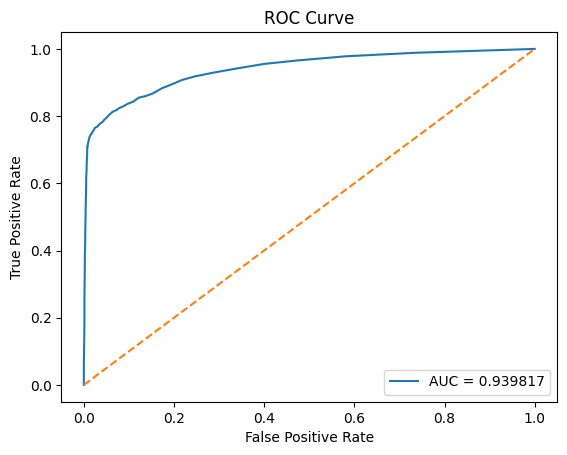

In [49]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label=f'AUC = {test_auc:f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [51]:
dummy_list = ["person_home_ownership","loan_intent"]

X_submit = pd.get_dummies(X_submit,columns=dummy_list)

grade_mapping = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7      }

X_submit['loan_grade'] = X_submit['loan_grade'].map(grade_mapping)

X_submit['cb_person_default_on_file'] = X_submit['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})

/tmp/ipykernel_30/881068673.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_submit['cb_person_default_on_file'] = X_submit['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})


In [55]:
submit_pred = rf_clf.predict_proba(X_submit)[:,1]

In [60]:
submission = pd.DataFrame({
    'loan_status': submit_pred
})

submission.index = submit_id

In [61]:
submission.to_csv("submission.csv")